Image colorization project :
We train a CNN to take in greyscale images of ... and output their colorful and plausible colorization.

Imports required :

torch

skimage ? only used for rgb - lab parsing. Maybe we can do that ourselves to make some differentiation with the original project?

numpy

matplotlib

PIL ? only used to open images to rgb. We can use another library

In [113]:
import matplotlib.pyplot as plt 
import numpy as np
from PIL import Image
from skimage import color
from scipy.ndimage import gaussian_filter

import torch
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F

## Load data, augment it, transform it to LAB compute stats on colors

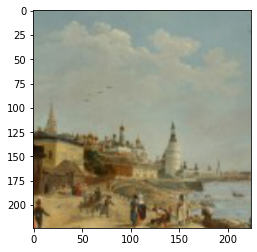

tensor([[[133, 134, 133,  ..., 136, 134, 134],
         [133, 133, 132,  ..., 136, 134, 134],
         [133, 133, 132,  ..., 136, 134, 134],
         ...,
         [177, 197, 199,  ...,  94,  86,  67],
         [177, 191, 193,  ..., 119,  98,  73],
         [180, 191, 188,  ..., 127, 102,  75]],

        [[149, 149, 150,  ..., 156, 154, 154],
         [150, 149, 149,  ..., 156, 154, 154],
         [150, 150, 150,  ..., 156, 154, 154],
         ...,
         [ 88, 107, 126,  ...,  83,  77,  59],
         [ 83,  97, 119,  ..., 106,  85,  62],
         [ 83,  93, 112,  ..., 110,  86,  61]],

        [[142, 144, 146,  ..., 154, 152, 152],
         [144, 145, 147,  ..., 154, 152, 152],
         [145, 147, 148,  ..., 154, 152, 152],
         ...,
         [ 40,  57,  82,  ...,  56,  51,  33],
         [ 33,  45,  72,  ...,  78,  58,  35],
         [ 30,  39,  64,  ...,  82,  58,  33]]], dtype=torch.uint8)


In [114]:
#Data loading
from torchvision import datasets, transforms, utils

transform = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.PILToTensor(),
])

dataset = datasets.ImageFolder("dataset_updated/training_set/train",transform=transform)
loader = data.DataLoader(dataset, batch_size = 4, shuffle = True)

images, labels = next(iter(loader))


img = images[0]
plt.imshow(transforms.functional.to_pil_image(img))
plt.show()
print(img)
img2 = img.numpy()

img shape :  (3, 224, 224)
img in rgb2lab [[[133 134 133 ... 136 134 134]
  [133 133 132 ... 136 134 134]
  [133 133 132 ... 136 134 134]
  ...
  [177 197 199 ...  94  86  67]
  [177 191 193 ... 119  98  73]
  [180 191 188 ... 127 102  75]]

 [[149 149 150 ... 156 154 154]
  [150 149 149 ... 156 154 154]
  [150 150 150 ... 156 154 154]
  ...
  [ 88 107 126 ...  83  77  59]
  [ 83  97 119 ... 106  85  62]
  [ 83  93 112 ... 110  86  61]]

 [[142 144 146 ... 154 152 152]
  [144 145 147 ... 154 152 152]
  [145 147 148 ... 154 152 152]
  ...
  [ 40  57  82 ...  56  51  33]
  [ 33  45  72 ...  78  58  35]
  [ 30  39  64 ...  82  58  33]]]
(224, 224, 3)
img shape :  (3, 224, 224)
img in rgb2lab [[[133 134 133 ... 136 134 134]
  [133 133 132 ... 136 134 134]
  [133 133 132 ... 136 134 134]
  ...
  [177 197 199 ...  94  86  67]
  [177 191 193 ... 119  98  73]
  [180 191 188 ... 127 102  75]]

 [[149 149 150 ... 156 154 154]
  [150 149 149 ... 156 154 154]
  [150 150 150 ... 156 154 154]
  ...


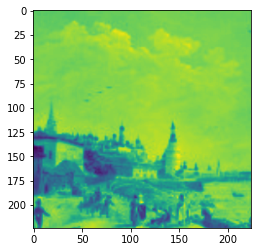

In [115]:
#LAB transform

def rgb2lab(img):
    #INPUT  RGB image of shape (...,3,H,W)
    #OUTPUT LAB image of shape (...,H,W,3) 
    print("img shape : ",img.shape)
    print("img in rgb2lab", img)
    lab_imgs = color.rgb2lab(img,channel_axis = 0)
    return np.transpose(lab_imgs,(1,2,0))

print(rgb2lab(img2).shape) 
print(rgb2lab(img2)) 

def separateChannels(imageLAB):
    #Input : LAB image with format (H,W,3)
    l = imageLAB[:,:,0]
    a = imageLAB[:,:,1]
    b = imageLAB[:,:,2]
    return l,a,b

l,a,b = separateChannels(rgb2lab(img2))
plt.imshow(l)
plt.show()



### Color stats

In [116]:
#Color stats (auxiliary functions)

def getDiscretisedColor(a,b,gridSize):
    a = np.round(a/gridSize) * gridSize
    b = np.round(b/gridSize) * gridSize
    return (a,b)

def getMatrixIndex(a,b,gridSize):
    i = (a + 500) / gridSize
    j = (b + 200) / gridSize
    return (int(i),int(j))

def getColorValue(i,j,gridSize):
    a = i * gridSize - 500
    b = j * gridSize - 200
    return (a,b)

img shape :  (3, 224, 224)
img in rgb2lab [[[ 39  37  35 ...  22  22  22]
  [ 38  36  34 ...  23  24  23]
  [ 38  37  35 ...  25  25  24]
  ...
  [ 28  29  28 ... 136 159 162]
  [ 29  30  30 ... 115 141 158]
  [ 31  32  32 ...  93 115 141]]

 [[ 24  22  20 ...  19  19  20]
  [ 25  23  21 ...  21  22  21]
  [ 26  24  22 ...  23  23  22]
  ...
  [ 19  20  18 ...  99 119 119]
  [ 21  21  19 ...  80 104 117]
  [ 22  23  22 ...  60  80 104]]

 [[ 10   8   6 ...  11  10  11]
  [  9   7   5 ...   8   9   8]
  [ 10   8   6 ...  10  10   9]
  ...
  [ 10  10   8 ...  65  86  87]
  [ 11  11   9 ...  47  71  86]
  [ 12  13  11 ...  28  49  74]]]
img shape :  (3, 224, 224)
img in rgb2lab [[[ 39  37  35 ...  22  22  22]
  [ 38  36  34 ...  23  24  23]
  [ 38  37  35 ...  25  25  24]
  ...
  [ 28  29  28 ... 136 159 162]
  [ 29  30  30 ... 115 141 158]
  [ 31  32  32 ...  93 115 141]]

 [[ 24  22  20 ...  19  19  20]
  [ 25  23  21 ...  21  22  21]
  [ 26  24  22 ...  23  23  22]
  ...
  [ 19  20  18

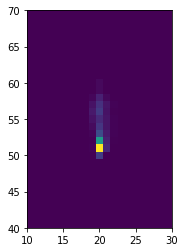

37
[(0, 0), (10, -10), (10, 0), (10, 10), (10, 20), (20, -10), (20, 0), (20, 10), (20, 20), (30, -10), (30, 0), (30, 10), (30, 20), (40, -10), (40, 0), (40, 10), (40, 20), (40, 30), (50, -10), (50, 0), (50, 10), (50, 20), (50, 30), (60, -10), (60, 0), (60, 10), (60, 20), (70, -10), (70, 0), (70, 10), (70, 20), (80, -10), (80, 0), (80, 10), (90, -10), (90, 0), (100, 0)]
[0.05136660023774561, 0.0029740053143136845, 0.28027323264107407, 0.03078237535836655, 0.0010598035102440389, 0.00190764631843927, 0.15690336340116076, 0.026088647647017692, 0.002104310887350535, 0.004326620516047829, 0.06468516187679184, 0.019878417593175303, 0.0029455982099153904, 0.008085098944129782, 0.043917383399762255, 0.01566761065659744, 0.00282541430669184, 0.00107291448150479, 0.013652891406195371, 0.03343734703866862, 0.0163209740577582, 0.002899709810502762, 0.0010532480246136634, 0.019380200685266764, 0.047920599958044895, 0.013384116495349976, 0.0020190895741556535, 0.01319837773582267, 0.04010427592476050

In [117]:
#Color stats

# need dataset express like that: list of images (as tensor) with dim H x W x 2 ...
#image_test = rgb2lab(img2) # need to change dim order of color stat code... ?
#images = [np.random.rand(3,3,2) * 100]
#images = [image_test[:][:][1:2]]
#print(image_test.shape)
#print(images[0])

# Initialise the proba distribution of ab pairs in the images dataset (discretised).
gridSize = 10 # too big ?
colorProbabilities = np.zeros((1000 // gridSize, 400 // gridSize))

# Compute the proba distribution of the ab pairs in the images dataset (discretised).
nbOfAnalysedPixels = 0
for images in loader:
    for image in images[0]: # strange... is it ok ?
        image = image.numpy()
        image = rgb2lab(image)[:][:][1:2]
        for h in range (image.shape[0]):
            for w in range (image.shape[1]):
                (a,b) = getDiscretisedColor(image[h][w][0],image[h][w][1],gridSize)
                (i,j) = getMatrixIndex(a,b,gridSize)
                colorProbabilities[i][j] += 1
                nbOfAnalysedPixels += 1
colorProbabilities = colorProbabilities / nbOfAnalysedPixels

# Smooth the proba distribution of the ab pairs in the images dataset.
sigma = 5 # gaussian kernel parameter
#colorProbabilities = gaussian_filter(colorProbabilities, sigma=sigma) # is it ok ? add a lot of value in gamut... take proba treshold ?

# + display distribution in 2d plot ? like in paper (here, very simple)
plt.imshow(colorProbabilities, interpolation='none')
plt.xlim(10, 30) # need to be dynamic !
plt.ylim(40, 70)
plt.show()

# Get the vector of proba of ab pairs that are "in gamut"
inGamutColors = []
inGamutColorsProbas = []
for i in range (colorProbabilities.shape[0]):
    for j in range (colorProbabilities.shape[1]):
        currentColorPorba = colorProbabilities[i][j]
        if currentColorPorba >= 0.001: # put a treshold ? if we use smoothing 
            (a,b) = getColorValue(i,j,gridSize)
            inGamutColors.append((a,b))
            inGamutColorsProbas.append(currentColorPorba)
        
Q = len(inGamutColors) 
p_smooth = torch.tensor(inGamutColorsProbas)
print(Q)
print(inGamutColors)
print(inGamutColorsProbas)
#Q = 1 # to remove


### Class rebalancing

In [118]:
#Define pixel weight vector (class rebalancing)

# Set the parameters (from paper, need empirical value).
lambda_uniform = 1/2 

# Compute a smooth version of the empirical pixel color distribution.
#p_smooth = p # how to do that ? gaussian kernel ? done at previous cell...

# Compute the weight vector.
pixelsWeights = torch.reciprocal((1 - lambda_uniform) * p_smooth + lambda_uniform / Q)

# Normalise the weight vector according to p_smooth (E[W] = 1).
E_W = torch.sum(p_smooth * pixelsWeights)
scale_factor = 1 / E_W
pixelsWeights = scale_factor * pixelsWeights 

print(pixelsWeights)

tensor([1.0687, 2.7925, 0.2726, 1.4492, 2.9828, 2.8954, 0.4555, 1.5772, 2.8758,
        2.6720, 0.9135, 1.7861, 2.7951, 2.3860, 1.1809, 1.9622, 2.8064, 2.9814,
        2.0594, 1.3856, 1.9327, 2.7994, 2.9835, 1.8053, 1.1178, 2.0731, 2.8843,
        2.0827, 1.2480, 1.9558, 2.8421, 2.6537, 1.6016, 2.5098, 2.9812, 2.4365,
        2.4850], dtype=torch.float64)


## Define and instantiate Convolutional NN consistent with the description of the paper. Shown in table 4.

In [119]:
#NN def

class ColorizationCNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.l_cent = 50.
        self.l_norm = 100.
        self.ab_norm = 110.
        
        channels_block_1 = 64
        channels_block_2 = 128
        channels_block_3 = 256
        channels_block_4 = 512
        channels_block_5 = 512 #dilated
        channels_block_6 = 512 #dilated
        channels_block_7 = 512 
        channels_block_8 = 128 # transpose convolution necessary

        nb_colour_bins = 313
        # first conv block : 2 convs. from luminosity image to 64 features map from 3x3 kernels. 50% downsampling and normalization at the end.
        self.convBlock1 = nn.Sequential(nn.Conv2d(1,channels_block_1,(3,3), padding =1), 
                nn.ReLU(True), #inplace for memory efficiency can be used as no skip connections are used.
                nn.Conv2d(channels_block_1,channels_block_1,(3,3), padding =1,stride=2), #50% downsampling achieved with a 2 stride. 
                nn.ReLU(True),
                nn.BatchNorm2d(channels_block_1) #normalization over the 64 channels created
        )

        # second conv block. 2 covs. from 64 features to 128 features map from 3x3 kernels. 50% downsampling and normalization at the end.
        self.convBlock2 = nn.Sequential(nn.Conv2d(64,channels_block_2,(3,3), padding =1,), 
                nn.ReLU(True),
                nn.Conv2d(channels_block_2,channels_block_2,(3,3), padding =1,stride=2), #50% downsampling achieved with a 2 stride. 
                nn.ReLU(True),
                nn.BatchNorm2d(channels_block_2)
        )

        # third conv block. 3 convs. from 64 to 128 features map from 3x3 kernels. 50% downsampling and normalization at the end.
        self.convBlock3 = nn.Sequential(nn.Conv2d(channels_block_2,channels_block_3,(3,3), padding = 1,), 
                nn.ReLU(True),
                nn.Conv2d(channels_block_3,channels_block_3,(3,3), padding =1),
                nn.ReLU(True),
                nn.Conv2d(channels_block_3,channels_block_3,(3,3), padding =1,stride=2), #50% downsampling achieved with a 2 stride. 
                nn.ReLU(True),
                nn.BatchNorm2d(channels_block_3)
        )

        # fourth conv block. 3 convs. from 256 to 512 features map from 3x3 kernels. 50% downsampling and normalization at the end.
        self.convBlock4 = nn.Sequential(nn.Conv2d(channels_block_3,channels_block_4,(3,3), padding =1,),
                nn.ReLU(True),
                nn.Conv2d(channels_block_4,channels_block_4,(3,3), padding = 1),
                nn.ReLU(True),
                nn.Conv2d(channels_block_4,channels_block_4,(3,3), padding = 1), #50% downsampling achieved with a 2 stride. 
                nn.ReLU(True),
                nn.BatchNorm2d(channels_block_4)
        )
        
        #fifth conv block. 3 convs. no change in nb feature maps. 3x3 kernels with 2 dilation and 2 padding to not downscale. normalization at the end.

        self.convBlock5 = nn.Sequential(nn.Conv2d(channels_block_4,channels_block_5,(3,3),dilation=2,padding=2),
                nn.ReLU(True),
                nn.Conv2d(channels_block_5,channels_block_5,(3,3),dilation=2,padding=2),
                nn.ReLU(True),
                nn.Conv2d(channels_block_5,channels_block_5,(3,3),dilation=2,padding=2), #50% downsampling achieved with a 2 stride. 
                nn.ReLU(True),
                nn.BatchNorm2d(channels_block_5)
        )

        #sixth conv block. same as 5
        self.convBlock6 = nn.Sequential(nn.Conv2d(channels_block_5,channels_block_6,(3,3),dilation=2,padding=2),
                nn.ReLU(True),
                nn.Conv2d(channels_block_6,channels_block_6,(3,3),dilation=2,padding=2),
                nn.ReLU(True),
                nn.Conv2d(channels_block_6,channels_block_6,(3,3),dilation=2,padding=2), #50% downsampling achieved with a 2 stride. 
                nn.ReLU(True),
                nn.BatchNorm2d(channels_block_6)
        )

        #seventh conv block : 3 convs with 3x3 kernels.
        self.convBlock7 = nn.Sequential(nn.Conv2d(channels_block_6,channels_block_7,(3,3),padding =1,),
                nn.ReLU(True),
                nn.Conv2d(channels_block_7,channels_block_7,(3,3),padding =1,),
                nn.ReLU(True),
                nn.Conv2d(channels_block_7,channels_block_7,(3,3),padding =1,), #50% downsampling achieved with a 2 stride. 
                nn.ReLU(True),
                nn.BatchNorm2d(channels_block_7)
        )

        #eighth conv block : 1 inverse conv to upsample then 2 convs with 3x3 kernels default parameters. Final convolution with 1x1 for classification into a colour bin
        self.convBlock8 = nn.Sequential(nn.ConvTranspose2d(channels_block_7,channels_block_8,(4,4),stride = 2, padding =1),
                nn.ReLU(True),
                nn.Conv2d(channels_block_8,channels_block_8,(3,3),padding = 1),
                nn.ReLU(True),
                nn.Conv2d(channels_block_8,channels_block_8,(3,3),padding = 1), #50% downsampling achieved with a 2 stride. 
                nn.ReLU(True),
                nn.Conv2d(channels_block_8,nb_colour_bins,kernel_size=1) #1x1 kernel for classification in each colour bin (value will be soft maxed for probability)
        )

        self.outputLayer = nn.Conv2d(nb_colour_bins,2,kernel_size=1,dilation=1, bias = False) # 1x1 kernel to get 2 channel values of a and b respectively
    
    def forward(self, luminosity_image):
        h1 = self.convBlock1((luminosity_image-self.l_cent)/self.l_norm) #normalize luminosity to be on scale of 0 to 100
        h2 = self.convBlock2(h1)
        h3 = self.convBlock3(h2)
        h4 = self.convBlock4(h3)
        h5 = self.convBlock5(h4)
        h6 = self.convBlock6(h5)
        h7 = self.convBlock7(h6)
        h8 = self.convBlock8(h7)

        colour_bin_proba = (nn.Softmax(dim=1))(h8)
        output = self.outputLayer(colour_bin_proba)
        upscaled_output = (nn.Upsample(scale_factor=4, mode='bilinear'))(output) # bilinear upscale to agree with input image size 

        return upscaled_output * self.ab_norm # denormalize to cover whole ab value range
        
colCNN = ColorizationCNN()

## Define optimizer

In [120]:
#ADAM
initial_lr = 3e-5
optimizer = torch.optim.Adam(colCNN.parameters(),lr = initial_lr , weight_decay=1e-3)
# lr will be decreased further when loss plateaus in the training loop. 

## Define Loss

### Soft encoding

In [121]:
#Convert a true image Y[BxHxWx2] to pixels color distributions Z[BxHxWxQ] (soft encoding)

# Define a distance measure bewteen two colors (a,b).
colorDistance = lambda c1, c2: np.sqrt((c1[0]-c2[0])**2 + (c1[1]-c2[1])**2)


# Define a Gaussian kernel.
def gaussianKernel(distances):
    sigma = 5
    weights = np.exp(-(distances**2) / sigma)
    return weights


def getColorDistribution(Y,nbOfNeighbors):
    # Initiate a tensor to store the distributions produced from Y.
    Z = torch.zeros(Y.shape[0], Y.shape[1], Y.shape[2], Q)

    # Produce a color distribution for each pixel of the image.
    for i in range (Z.shape[0]):
        print(i)
        for h in range (Z.shape[1]):
            for w in range (Z.shape[2]):
                color_true = Y[i][h][w]
                distances = np.array([colorDistance(color,color_true) for color in inGamutColors]) # not efficient... possible to do better ?
                nearestNeighborsIndexs = (-distances).argsort()[:nbOfNeighbors]
                weights = torch.from_numpy(gaussianKernel(distances[nearestNeighborsIndexs]))
                for j in range (weights.shape[0]):
                    Z[i][h][w][nearestNeighborsIndexs[j]] = weights[j]
    
    # Return the produced distributions.
    return Z


In [122]:
#Z = getColorDistribution(torch.rand(4,224,224,2), 5) #test

In [123]:
#print(torch.sum(Z)) ## strange

### Point estimate

In [124]:
#Convert the pixel color distributions in Z[HxWxQ] to true picture estimate Y[HxWx2] (point estimate)

# No need to be very efficient because only use when we predict (after training) ? difficult to rewrite with tensor operation

def getPictureEstimate(Z,T):
    # Initiate a tensor to store the image estimated from Z.
    Y_estimate = torch.zeros(Z.shape[0], Z.shape[1], 2)
    
    # Estimate the Lab color for each pixel of the image.
    for h in range (Y_estimate.shape[0]):
        for w in range (Y_estimate.shape[1]):
            # Re-ajust the temperture of the current distribution.
            reajustedDistribution = torch.exp(torch.log10(Z[h][w]) / T)  / torch.sum(torch.exp(torch.log10(Z[h][w]) / T), 2) # check again...

            # Compute the anneled-mean of the current distribution. 
            a, b = 0, 0
            for q in range (Z.shape[2]):
                a += reajustedDistribution[q] * inGamutColors[q][0]
                b += reajustedDistribution[q] * inGamutColors[q][1]
            
            # Estimate the Lab color for the current pixel.
            Y_estimate[h][w][0] = a
            Y_estimate[h][w][1] = b
    
    # Return the estimated picture.
    return Y_estimate

### Loss function

In [125]:
# Take Z[BxHxWxQ] as input where B is the batch size

#v(Z_hw) weight in paper (section 2)

def getPixelsWeights(Z_batch):
    W = torch.argmax(Z_batch, dim=3)
    for i in range(W.size(dim=0)):
        for h in range(W.size(dim=1)):
            for w in range(W.size(dim=2)):
                W[i,h,w] = pixelsWeights[W[i,h,w]]

    return W

In [126]:
# Take Z[BxHxWxQ] as input where B is the batch size

#loss function 

def multinomialCrossEntropyLoss(Z_estimate_batch, Z_batch):
    W = getPixelsWeights(Z_batch)
    L = - torch.sum(torch.sum(torch.sum(W * torch.sum(Z_batch * torch.log10(Z_estimate_batch), dim=3), dim=2), dim=1))

    return L

#Loss = multinomialCrossEntropyLoss(torch.rand(4,224,224,Q), torch.rand(4,224,224,Q)) # test
#print(Loss)

## Main training loop and additional function TBD

Define a trining step: for each image in a batch : prediction, loss, backprop loss

In [127]:


def training_step(optim,loss_fct,network,dataloader):
    '''
        Function to execute a single training step
            Input : 
                optim = pytorch optimize used for the training step
                loss_fct = loss function used to compare the predicted output to ground truth
                dataloader = pytorch data loader to provide the training data used in the training step

            Output :
                average loss over the training step

    '''

    iteration_losses = []
    batch_size = 4

    for data in dataloader:
        images,_ = data

        lab_images = []
        l_images = []

        for i in range(images.shape[0]):
            lab_im = rgb2lab(images[i].numpy())
            lab_images.append(lab_im)
            l_images.append(lab_im[:,:,0])

        lab_images = torch.tensor(np.array(lab_images))
        l_images = torch.tensor(np.array(l_images))
        l_images = torch.unsqueeze(l_images,dim=1)
        print(l_images.shape)
        predicted_colour_probability = network.forward(l_images.float())
        print(predicted_colour_probability.shape)
        loss = loss_fct(predicted_colour_probability,getColorDistribution(lab_images, batch_size))
        iteration_losses.append(loss.item())

        optim.zero_grad() 
        loss.backward()
        optim.step()

    return sum(iteration_losses) / len(iteration_losses) # average loss of training iteration

In [128]:
nb_steps = 10
losses = np.zeros(nb_steps)


for step in range(nb_steps):
    print('step :',step,end='\r')
    losses[step] = training_step(optimizer,multinomialCrossEntropyLoss,colCNN,loader)


img shape :  (3, 224, 224)
img in rgb2lab [[[134 133 131 ... 163 155 154]
  [132 131 130 ... 165 156 151]
  [132 131 129 ... 168 157 147]
  ...
  [ 98 102 101 ... 119 118 123]
  [ 98 101 101 ... 118 117 121]
  [101 103 103 ... 118 117 118]]

 [[102 101  99 ... 129 121 119]
  [100  99  98 ... 131 122 116]
  [100  99  97 ... 134 123 112]
  ...
  [ 78  81  79 ...  88  87  90]
  [ 78  80  79 ...  87  86  88]
  [ 79  80  79 ...  88  87  86]]

 [[ 51  50  48 ...  65  57  55]
  [ 49  48  47 ...  67  58  52]
  [ 49  48  46 ...  70  59  48]
  ...
  [ 25  29  29 ...  41  40  40]
  [ 25  28  29 ...  40  39  38]
  [ 26  29  29 ...  39  38  35]]]
img shape :  (3, 224, 224)
img in rgb2lab [[[134 133 131 ... 163 155 154]
  [132 131 130 ... 165 156 151]
  [132 131 129 ... 168 157 147]
  ...
  [ 98 102 101 ... 119 118 123]
  [ 98 101 101 ... 118 117 121]
  [101 103 103 ... 118 117 118]]

 [[102 101  99 ... 129 121 119]
  [100  99  98 ... 131 122 116]
  [100  99  97 ... 134 123 112]
  ...
  [ 78  81  79

KeyboardInterrupt: 

Plot losses

In [ ]:
x_axis = range(1,nb_steps)
plt.plot(x_axis,losses, label="train loss")

plt.xlabel('number of training steps')
plt.ylabel('avg loss')
plt.title('multinomial cross entropy loss')
plt.legend()
plt.show()

Show the neural network colorization of a specific image vs the real colors of that image